In [1]:
%matplotlib inline

import pandas as pd; 
import numpy as np;
pd.set_option('display.max_columns', None)
from sklearn.model_selection import train_test_split
from sklearn import preprocessing

from sklift.metrics import uplift_at_k
from sklift.viz import plot_uplift_preds
from sklift.models import SoloModel

from catboost import CatBoostClassifier


In [2]:
#1. скачать набор данных маркетинговых кампаний отсюда https://www.kaggle.com/davinwijaya/customer-retention
df_marketing = pd.read_csv('data.csv')

In [3]:
#2. Переименовать поля (conversion -> target, offer -> treatment)
df_marketing.rename(columns= {'conversion': 'target', 'offer': 'treatment'}, inplace=True)

In [4]:
df_marketing.describe()

,recency,history,used_discount,used_bogo,is_referral,target
count,64000.000000,64000.000000,64000.000000,64000.000000,64000.000000,64000.000000
mean,5.763734,242.085656,0.551031,0.549719,0.502250,0.146781
std,3.507592,256.158608,0.497393,0.497526,0.499999,0.353890
min,1.000000,29.990000,0.000000,0.000000,0.000000,0.000000
25%,2.000000,64.660000,0.000000,0.000000,0.000000,0.000000
50%,6.000000,158.110000,1.000000,1.000000,1.000000,0.000000
75%,9.000000,325.657500,1.000000,1.000000,1.000000,0.000000
max,12.000000,3345.930000,1.000000,1.000000,1.000000,1.000000


In [5]:
# привести поле treatment к бинарному виду (1 или 0, т.е было какое-то предложение или нет) 
#- значение No Offer означает отсутствие коммуникации, а все остальные - наличие
df_marketing.loc[(df_marketing.treatment != "No Offer"), "treatment"] = 1
df_marketing.loc[(df_marketing.treatment == "No Offer"), "treatment"] = 0
# treatment не числовая колонка
df_marketing["treatment"]=df_marketing["treatment"].astype(int)
df_marketing.head(5)

,recency,history,used_discount,used_bogo,zip_code,is_referral,channel,treatment,target
0,10,142.44,1,0,Surburban,0,Phone,1,0
1,6,329.08,1,1,Rural,1,Web,0,0
2,7,180.65,0,1,Surburban,1,Web,1,0
3,9,675.83,1,0,Rural,1,Web,1,0
4,2,45.34,1,0,Urban,0,Web,1,0


In [6]:
#4. сделать feature engineering на ваше усмотрение (допускается свобода выбора методов)
df_marketing.isna().any(axis=None)

False

In [7]:
#сделаем dummy переменные
s1 = ['zip_code', 'channel']
df_marketing = pd.get_dummies(df_marketing, prefix=s1)
df_marketing.head(5)

,recency,history,used_discount,used_bogo,is_referral,treatment,target,zip_code_Rural,zip_code_Surburban,zip_code_Urban,channel_Multichannel,channel_Phone,channel_Web
0,10,142.44,1,0,0,1,0,0,1,0,0,1,0
1,6,329.08,1,1,1,0,0,1,0,0,0,0,1
2,7,180.65,0,1,1,1,0,0,1,0,0,0,1
3,9,675.83,1,0,1,1,0,1,0,0,0,0,1
4,2,45.34,1,0,0,1,0,0,0,1,0,0,1


In [8]:
def normalize(df, columns):
    result = df.copy()
    for feature_name in columns:
        max_value = df[feature_name].max()
        min_value = df[feature_name].min()
        result[feature_name] = (df[feature_name] - min_value) / (max_value - min_value)
    return result

In [9]:
#Нормализация колонки history recency
columns = ['history', 'recency']
df_features = normalize(df_marketing, columns)
df_features.head(5)

# x_array = np.array(df_marketing['history'])
# normalized_arr = preprocessing.normalize([x_array])
# df_marketing['history'] = normalized_arr[0]

,recency,history,used_discount,used_bogo,is_referral,treatment,target,zip_code_Rural,zip_code_Surburban,zip_code_Urban,channel_Multichannel,channel_Phone,channel_Web
0,0.818182,0.033912,1,0,0,1,0,0,1,0,0,1,0
1,0.454545,0.090198,1,1,1,0,0,1,0,0,0,0,1
2,0.545455,0.045435,0,1,1,1,0,0,1,0,0,0,1
3,0.727273,0.194768,1,0,1,1,0,1,0,0,0,0,1
4,0.090909,0.004629,1,0,0,1,0,0,0,1,0,0,1


In [10]:
#3. сделать разбиение набора данных на тренировочную и тестовую выборки
indices_train, indices_test = train_test_split(df_features.index, test_size=0.3, random_state=123)

#### 5. провести uplift-моделирование 3 способами: одна модель с признаком коммуникации (S learner), модель с трансформацией таргета (трансформация классов п. 2. 1) и вариант с двумя независимыми моделями

##### uplift-моделирование одна модель с признаком коммуникации (S learner)

In [11]:
X_train = df_features.loc[indices_train, :]
# нужно ли удялять эти колонки?
X_train.pop('target') 
X_train.pop('treatment')

y_train = df_features.loc[indices_train, 'target']
treat_train = df_features.loc[indices_train, 'treatment']

X_val = df_features.loc[indices_test, :]
X_val.pop('target') 
X_val.pop('treatment')

y_val = df_features.loc[indices_test, 'target']
treat_val =  df_features.loc[indices_test, 'treatment']

cat_features = []

models_results = {
    'approach': [],
    'uplift@30%': []
}

In [12]:
sm = SoloModel(CatBoostClassifier(iterations=20, thread_count=2, random_state=42, silent=True))
sm = sm.fit(X_train, y_train, treat_train, estimator_fit_params={'cat_features': cat_features})

uplift_sm = sm.predict(X_val)

In [13]:
df_up = pd.DataFrame({'treat':treat_val.tolist(), 'Y':y_val.tolist(), 'uplift_sm': uplift_sm.tolist()})
df_up_sort = df_up.sort_values('uplift_sm', ascending=False)
df_up_sort.head(30)

,treat,Y,uplift_sm
15294,1,0,0.236077
9588,1,1,0.223913
4533,0,0,0.167007
801,0,0,0.167007
8526,0,0,0.167007
16369,1,0,0.167007
12738,1,0,0.167007
14033,1,0,0.167007
13002,0,0,0.167007
17460,0,1,0.167007


In [26]:
# Так себе результат. Из топ 10 угадали 5 не угадали тоже 5 :( 
# Ну то есть там где высокий uplift должны быть сочетания 1 1 или 0 0
# а тут все подряд. Или я чтото упустил важное

uplift@30%: 0.0856


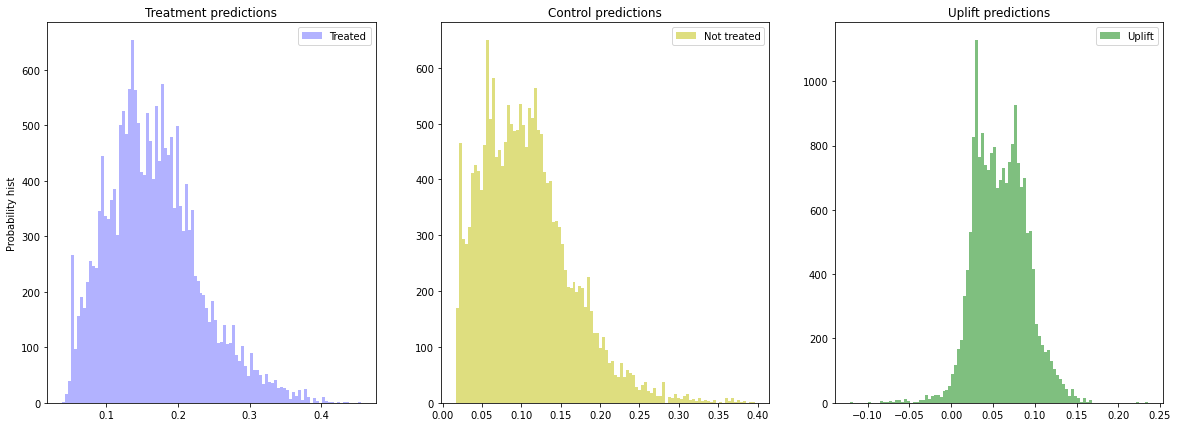

In [15]:
sm_score = uplift_at_k(y_true=y_val, uplift=uplift_sm, treatment=treat_val, strategy='by_group', k=0.3)
print(f'uplift@30%: {sm_score:.4f}')

models_results['approach'].append('SoloModel')
models_results['uplift@30%'].append(sm_score)

# Вот эти 2 строки вообще непонятны. sm это вроде модель, то есть некий алгоритм. откуда там данные?
# Получим условные вероятности выполнения целевого действия при взаимодействии для каждого объекта
sm_trmnt_preds = sm.trmnt_preds_
# И условные вероятности выполнения целевого действия без взаимодействия для каждого объекта
sm_ctrl_preds = sm.ctrl_preds_

# Отрисуем распределения вероятностей и их разность (uplift)
plot_uplift_preds(trmnt_preds=sm_trmnt_preds, ctrl_preds=sm_ctrl_preds);

#### Трансформация классов

In [16]:
from sklift.models import ClassTransformation


ct = ClassTransformation(CatBoostClassifier(iterations=20, thread_count=2, random_state=42, silent=True))
ct = ct.fit(X_train, y_train, treat_train, estimator_fit_params={'cat_features': cat_features})

uplift_ct = ct.predict(X_val)

ct_score = uplift_at_k(y_true=y_val, uplift=uplift_ct, treatment=treat_val, strategy='by_group', k=0.3)

models_results['approach'].append('ClassTransformation')
models_results['uplift@30%'].append(ct_score)

<ipython-input-16-6e5ebc9c94ea>:5: UserWarning: It is recommended to use this approach on treatment balanced data. Current sample size is unbalanced.
  ct = ct.fit(X_train, y_train, treat_train, estimator_fit_params={'cat_features': cat_features})


#### Две независимые модели

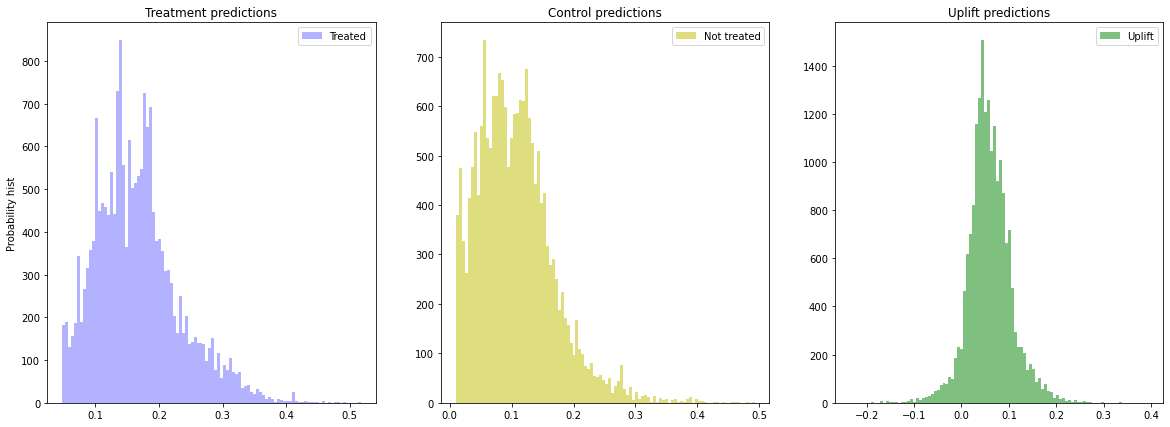

In [17]:
from sklift.models import TwoModels


tm = TwoModels(
    estimator_trmnt=CatBoostClassifier(iterations=20, thread_count=2, random_state=42, silent=True), 
    estimator_ctrl=CatBoostClassifier(iterations=20, thread_count=2, random_state=42, silent=True), 
    method='vanilla'
)
tm = tm.fit(
    X_train, y_train, treat_train,
    estimator_trmnt_fit_params={'cat_features': cat_features}, 
    estimator_ctrl_fit_params={'cat_features': cat_features}
)

uplift_tm = tm.predict(X_val)

tm_score = uplift_at_k(y_true=y_val, uplift=uplift_tm, treatment=treat_val, strategy='by_group', k=0.3)

models_results['approach'].append('TwoModels')
models_results['uplift@30%'].append(tm_score)

plot_uplift_preds(trmnt_preds=tm.trmnt_preds_, ctrl_preds=tm.ctrl_preds_);

#### 6. Вывести единую таблицу сравнения метрик uplift@10%, uplift@20% этих 3 моделей

In [18]:
pd.DataFrame(data=models_results).sort_values('uplift@30%', ascending=False)

,approach,uplift@30%
0,SoloModel,0.085582
1,ClassTransformation,0.082995
2,TwoModels,0.074646


#### 7. Построить модель UpliftTreeClassifier и попытаться описать словами полученное дерево

In [19]:
# !git clone https://github.com/ub8er/causalml.git
# %cd C:\Temp\causalml\
# !pip install -r C:\Temp\causalml\requirements.txt
# !python C:\Temp\causalml\setup.py build_ext --inplace
# !python C:\Temp\causalml\setup.py install

In [20]:
features = [col for col in X_train]

In [21]:
%%time
from IPython.display import Image
from causalml.inference.tree import UpliftTreeClassifier, UpliftRandomForestClassifier
from causalml.inference.tree import uplift_tree_string, uplift_tree_plot

uplift_model = UpliftTreeClassifier(max_depth=8, min_samples_leaf=200, min_samples_treatment=50,
                                    n_reg=100, evaluationFunction='KL', control_name='control')

uplift_model.fit(X_train.values,
                 treatment=treat_train.map({1: 'treatment1', 0: 'control'}).values,
                 y=y_train)

graph = uplift_tree_plot(uplift_model.fitted_uplift_tree, features)


Wall time: 21.8 s


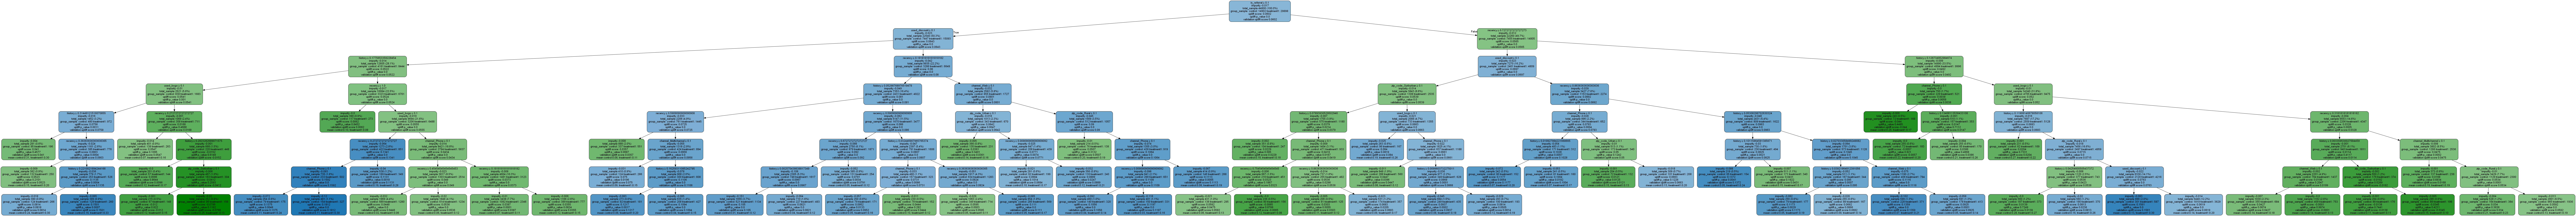

In [22]:
Image(graph.create_png())

Поробую предположить: Зеленые это наши клиенты, а синих лучше не трогать )

Дерево это алгоритм принятия решения. Узлы это условия по какому-то признаку. 
В конце концов надо решить: надо ли слать рекламу клиенту? 
    В листах дерева должно быть или число от -1 до 1 или булево.
    Не смог понять картинку с деревом